In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.0107 - acc: 0.3532
Epoch 00001: val_loss improved from inf to 3.46988, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_3_conv_checkpoint/001-3.4699.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 4.0110 - acc: 0.3532 - val_loss: 3.4699 - val_acc: 0.3897
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5526 - acc: 0.5894
Epoch 00002: val_loss improved from 3.46988 to 3.42486, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_3_conv_checkpoint/002-3.4249.hdf5
36805/36805 [==============================] - 34s 913us/sample - loss: 2.5531 - acc: 0.5893 - val_loss: 3.4249 - val_acc: 0.4927
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8941 - acc: 0.6879
Epoch 00003: val_loss did not improve f

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4109 - acc: 0.9540
Epoch 00029: val_loss did not improve from 3.42486
36805/36805 [==============================] - 34s 921us/sample - loss: 0.4114 - acc: 0.9539 - val_loss: 4.7619 - val_acc: 0.5891
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4361 - acc: 0.9501
Epoch 00030: val_loss did not improve from 3.42486
36805/36805 [==============================] - 34s 919us/sample - loss: 0.4361 - acc: 0.9500 - val_loss: 4.8155 - val_acc: 0.5882
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3858 - acc: 0.9569
Epoch 00031: val_loss did not improve from 3.42486
36805/36805 [==============================] - 34s 917us/sample - loss: 0.3857 - acc: 0.9569 - val_loss: 5.1063 - val_acc: 0.5672
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3918 - acc: 0.9568
Epoch 00032: val_loss did not improve from 3.42486
36805/36805 [=====

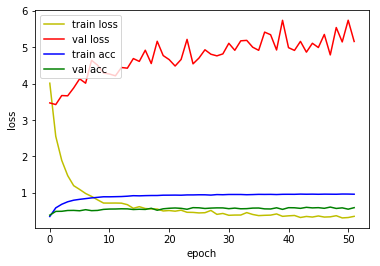

4815/4815 [==============================] - 2s 428us/sample - loss: 3.6859 - acc: 0.4590
Loss: 3.68593449231125 Accuracy: 0.45898235

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1548 - acc: 0.4332
Epoch 00001: val_loss improved from inf to 1.92991, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_4_conv_checkpoint/001-1.9299.hdf5
36805/36805 [==============================] - 35s 946us/sample - loss: 2.1548 - acc: 0.4332 - val_loss: 1.9299 - val_acc: 0.4326
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1042 - acc: 0.6867
Epoch 00002: val_loss improved from 1.92991 to 1.64474, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_4_conv_checkpoint/002-1.6447.hdf5
36805/36805 [==============================] - 30s 825us/sample - loss: 1.1041 - acc: 0.6867 - val_loss: 1.6447 - val_acc: 0.5758
Epoch 3/500
36800/36805 [=====================

Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9869
Epoch 00029: val_loss did not improve from 1.61935
36805/36805 [==============================] - 30s 819us/sample - loss: 0.0561 - acc: 0.9868 - val_loss: 2.7339 - val_acc: 0.6259
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9812
Epoch 00030: val_loss did not improve from 1.61935
36805/36805 [==============================] - 30s 823us/sample - loss: 0.0770 - acc: 0.9813 - val_loss: 2.8666 - val_acc: 0.6045
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9890
Epoch 00031: val_loss did not improve from 1.61935
36805/36805 [==============================] - 30s 820us/sample - loss: 0.0515 - acc: 0.9889 - val_loss: 2.9510 - val_acc: 0.6140
Epoch 32/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9842
Epoch 00032: val_loss did not improve from 1.61935
36805/36805 [=====

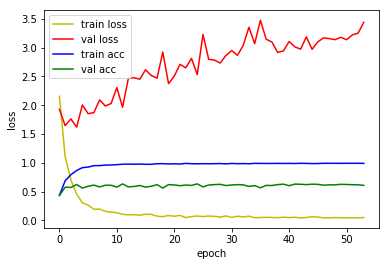

4815/4815 [==============================] - 2s 426us/sample - loss: 1.7336 - acc: 0.5811
Loss: 1.7336489571217808 Accuracy: 0.5811007

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8416 - acc: 0.4507
Epoch 00001: val_loss improved from inf to 1.80991, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_5_conv_checkpoint/001-1.8099.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.8416 - acc: 0.4507 - val_loss: 1.8099 - val_acc: 0.4433
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1548 - acc: 0.6529
Epoch 00002: val_loss improved from 1.80991 to 1.52176, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_5_conv_checkpoint/002-1.5218.hdf5
36805/36805 [==============================] - 31s 841us/sample - loss: 1.1549 - acc: 0.6528 - val_loss: 1.5218 - val_acc: 0.5448
Epoch 3/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9910
Epoch 00027: val_loss did not improve from 1.01736
36805/36805 [==============================] - 31s 843us/sample - loss: 0.0480 - acc: 0.9909 - val_loss: 1.2956 - val_acc: 0.7188
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9914
Epoch 00028: val_loss did not improve from 1.01736
36805/36805 [==============================] - 31s 838us/sample - loss: 0.0442 - acc: 0.9914 - val_loss: 1.2875 - val_acc: 0.7331
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9945
Epoch 00029: val_loss did not improve from 1.01736
36805/36805 [==============================] - 31s 841us/sample - loss: 0.0334 - acc: 0.9945 - val_loss: 1.4937 - val_acc: 0.7046
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9940
Epoch 00030: val_loss did not improve from 1.01736
36805/36805 [==================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9942
Epoch 00057: val_loss did not improve from 1.01736
36805/36805 [==============================] - 31s 836us/sample - loss: 0.0285 - acc: 0.9942 - val_loss: 1.4814 - val_acc: 0.7347

1D_CNN_custom_multi_3_concat_ch_32_BN_5_conv Model


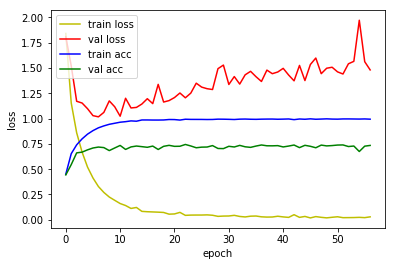

4815/4815 [==============================] - 2s 461us/sample - loss: 1.1376 - acc: 0.6818
Loss: 1.1375652820274218 Accuracy: 0.6818276

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8220 - acc: 0.4476
Epoch 00001: val_loss improved from inf to 1.47524, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_6_conv_checkpoint/001-1.4752.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.8219 - acc: 0.4476 - val_loss: 1.4752 - val_acc: 0.5309
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1475 - acc: 0.6543
Epoch 00002: val_loss improved from 1.47524 to 1.06220, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_6_conv_checkpoint/002-1.0622.hdf5
36805/36805 [==============================] - 32s 862us/sample - loss: 1.1476 - acc: 0.6543 - val_loss: 1.0622 - val_acc: 0.6879
Epoch 3/500
36800/36805 [======================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9855
Epoch 00025: val_loss did not improve from 0.51934
36805/36805 [==============================] - 32s 859us/sample - loss: 0.0704 - acc: 0.9854 - val_loss: 0.5270 - val_acc: 0.8696
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9907
Epoch 00026: val_loss improved from 0.51934 to 0.49186, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_6_conv_checkpoint/026-0.4919.hdf5
36805/36805 [==============================] - 32s 864us/sample - loss: 0.0544 - acc: 0.9907 - val_loss: 0.4919 - val_acc: 0.8798
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9920
Epoch 00027: val_loss did not improve from 0.49186
36805/36805 [==============================] - 31s 852us/sample - loss: 0.0495 - acc: 0.9919 - val_loss: 0.5324 - val_acc: 0.8665
Epoch 28/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9943
Epoch 00054: val_loss did not improve from 0.49186
36805/36805 [==============================] - 32s 859us/sample - loss: 0.0281 - acc: 0.9942 - val_loss: 0.5649 - val_acc: 0.8768
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9955
Epoch 00055: val_loss did not improve from 0.49186
36805/36805 [==============================] - 32s 861us/sample - loss: 0.0224 - acc: 0.9954 - val_loss: 0.6005 - val_acc: 0.8791
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9968
Epoch 00056: val_loss did not improve from 0.49186
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0193 - acc: 0.9968 - val_loss: 0.6037 - val_acc: 0.8686
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9981
Epoch 00057: val_loss did not improve from 0.49186
36805/36805 [==================

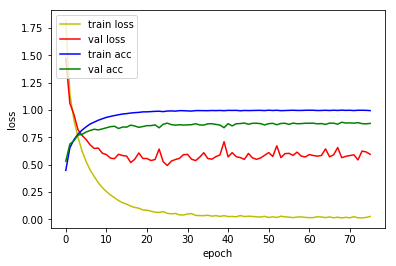

4815/4815 [==============================] - 2s 464us/sample - loss: 0.5799 - acc: 0.8513
Loss: 0.5799085622635958 Accuracy: 0.85129803

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7707 - acc: 0.4525
Epoch 00001: val_loss improved from inf to 1.67224, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_7_conv_checkpoint/001-1.6722.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.7707 - acc: 0.4525 - val_loss: 1.6722 - val_acc: 0.4314
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0409 - acc: 0.6885
Epoch 00002: val_loss improved from 1.67224 to 0.86598, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_7_conv_checkpoint/002-0.8660.hdf5
36805/36805 [==============================] - 33s 903us/sample - loss: 1.0411 - acc: 0.6884 - val_loss: 0.8660 - val_acc: 0.7484
Epoch 3/500
36800/36805 [=====================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9837
Epoch 00024: val_loss did not improve from 0.26628
36805/36805 [==============================] - 33s 906us/sample - loss: 0.0685 - acc: 0.9837 - val_loss: 0.2763 - val_acc: 0.9259
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9865
Epoch 00025: val_loss did not improve from 0.26628
36805/36805 [==============================] - 33s 900us/sample - loss: 0.0597 - acc: 0.9865 - val_loss: 0.2855 - val_acc: 0.9250
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9875
Epoch 00026: val_loss did not improve from 0.26628
36805/36805 [==============================] - 33s 895us/sample - loss: 0.0562 - acc: 0.9875 - val_loss: 0.3052 - val_acc: 0.9241
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9885
Epoch 00027: val_loss did not improve from 0.26628
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9971
Epoch 00053: val_loss did not improve from 0.26472
36805/36805 [==============================] - 33s 895us/sample - loss: 0.0167 - acc: 0.9971 - val_loss: 0.3775 - val_acc: 0.9187
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9965
Epoch 00054: val_loss did not improve from 0.26472
36805/36805 [==============================] - 33s 898us/sample - loss: 0.0181 - acc: 0.9965 - val_loss: 0.3367 - val_acc: 0.9257
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9963
Epoch 00055: val_loss did not improve from 0.26472
36805/36805 [==============================] - 33s 892us/sample - loss: 0.0173 - acc: 0.9963 - val_loss: 0.2921 - val_acc: 0.9329
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9982
Epoch 00056: val_loss did not improve from 0.26472
36805/36805 [==================


1D_CNN_custom_multi_3_concat_ch_32_BN_7_conv Model


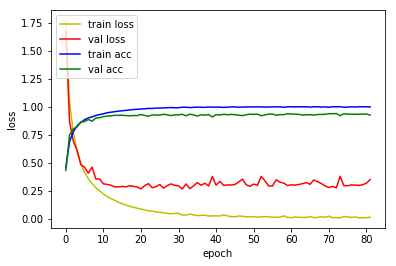

4815/4815 [==============================] - 2s 470us/sample - loss: 0.3168 - acc: 0.9161
Loss: 0.3168294546883921 Accuracy: 0.91609555

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8906 - acc: 0.4167
Epoch 00001: val_loss improved from inf to 1.61971, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_8_conv_checkpoint/001-1.6197.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.8905 - acc: 0.4167 - val_loss: 1.6197 - val_acc: 0.4673
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9677 - acc: 0.7104
Epoch 00002: val_loss improved from 1.61971 to 0.74473, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_32_BN_8_conv_checkpoint/002-0.7447.hdf5
36805/36805 [==============================] - 34s 919us/sample - loss: 0.9676 - acc: 0.7104 - val_loss: 0.7447 - val_acc: 0.7706
Epoch 3/500
36800/36805 [=====================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9849
Epoch 00024: val_loss did not improve from 0.20304
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0574 - acc: 0.9849 - val_loss: 0.2088 - val_acc: 0.9399
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9870
Epoch 00025: val_loss did not improve from 0.20304
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0534 - acc: 0.9870 - val_loss: 0.2157 - val_acc: 0.9357
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0563 - acc: 0.9850
Epoch 00026: val_loss did not improve from 0.20304
36805/36805 [==============================] - 34s 927us/sample - loss: 0.0564 - acc: 0.9849 - val_loss: 0.2235 - val_acc: 0.9359
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9882
Epoch 00027: val_loss did not improve from 0.20304
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9977
Epoch 00053: val_loss did not improve from 0.20304
36805/36805 [==============================] - 34s 929us/sample - loss: 0.0131 - acc: 0.9976 - val_loss: 0.2863 - val_acc: 0.9336
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9940
Epoch 00054: val_loss did not improve from 0.20304
36805/36805 [==============================] - 34s 933us/sample - loss: 0.0217 - acc: 0.9940 - val_loss: 0.2385 - val_acc: 0.9455
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9952
Epoch 00055: val_loss did not improve from 0.20304
36805/36805 [==============================] - 34s 925us/sample - loss: 0.0177 - acc: 0.9951 - val_loss: 0.2327 - val_acc: 0.9434
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9973
Epoch 00056: val_loss did not improve from 0.20304
36805/36805 [==================

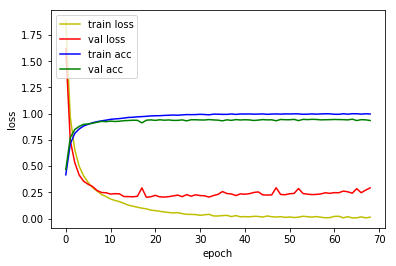

4815/4815 [==============================] - 3s 567us/sample - loss: 0.2759 - acc: 0.9161
Loss: 0.2758556693297185 Accuracy: 0.91609555



In [10]:
base = '1D_CNN_custom_multi_3_concat_ch_32_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 557us/sample - loss: 1.7336 - acc: 0.5811
Loss: 1.7336489571217808 Accuracy: 0.5811007

1D_CNN_custom_multi_3_concat_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 3s 583us/sample - loss: 0.5799 - acc: 0.8513
Loss: 0.5799085622635958 Accuracy: 0.85129803

1D_CNN_custom_multi_3_concat_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activ

4815/4815 [==============================] - 3s 641us/sample - loss: 0.2759 - acc: 0.9161
Loss: 0.2758556693297185 Accuracy: 0.91609555


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_concat_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 727us/sample - loss: 3.7941 - acc: 0.5688
Loss: 3.794078778774939 Accuracy: 0.56884736

1D_CNN_custom_multi_3_concat_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 3s 676us/sample - loss: 0.7184 - acc: 0.8569
Loss: 0.7183662781091494 Accuracy: 0.8569055

1D_CNN_custom_multi_3_concat_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activa

4815/4815 [==============================] - 4s 771us/sample - loss: 0.3644 - acc: 0.9207
Loss: 0.3644367678576417 Accuracy: 0.9206646
